### Mega Case Study - Make a Hybrid Deep Learning Model

In the end, a ranking of the predicted probabilities that each customer has cheated is obtained

#### Part 1 - Identify the frauds with the Self-Organizing Map

In [ ]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

!pip install minisom

# importing the dataset
cwd = Path.cwd()
path = cwd / "datasets/SOM Credit Card"
dataset = pd.read_csv(os.path.join(path, 'Credit_Card_Applications.csv'))

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
sc.fit_transform(X)

# Training the SOM
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len=15,
              sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(data=X, num_iteration=100)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(X.shape)
y.shape

(690, 15)


(690,)

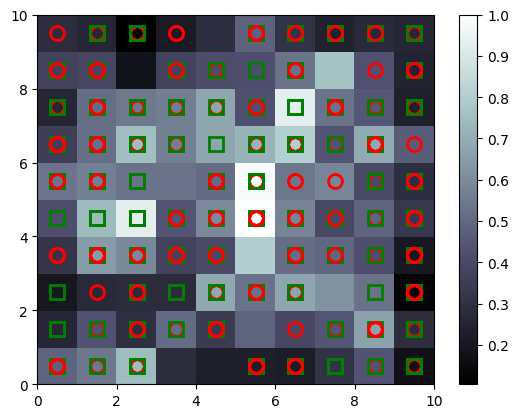

In [ ]:
# Visualising the results
from pylab import bone, pcolor, colorbar, plt, show
bone()
pcolor(som.distance_map().T)
colorbar()  # lengends of all the colors
markers = ['o', 's']  # o - circles, s - squares
colors = ['r', 'g']  # r - red, g - green
# red circle - customer got approval
# green square - didn't get approval

for i, x in enumerate(X):
  w = som.winner(x)
  plt.plot(w[0] + 0.5,
       w[1] + 0.5,
       markers[y[i]],
       markeredgecolor = colors[y[i]],
       markerfacecolor = 'None',
       markersize = 10,
       markeredgewidth = 2
       )  # on this winning node, plot the marker
show()

In [ ]:
# Finding the frauds
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(5,4)],
                        mappings[(5,5)],
                        mappings[(6,7)],
                        mappings[(2,4)]),
                        axis=0)
frauds = sc.inverse_transform(frauds)
len(frauds)

25

In [ ]:
frauds.shape

(25, 15)

In [ ]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
3939779227438
3940238229340
3941207427589
3940761161866
3940312149124
3940275189232
3940612323382
3940386818095
3940541150617
3940213006711
3941132259160
3940325884219
3941232400489
3940635797908
3939970270123
3932092319089
3932199452830
3932496880069
3932312829796
3929710403887
3936422869678
3938823514555
3938976348703
3939184872418
3939188118895


#### Part 2 - Going from Unsupervised --> Supervised Deep Learning

Creating the matrix of features

In [ ]:
customers = dataset.iloc[:, 1:].values
customers.shape

(690, 15)

Creating the dependent variable

In [ ]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

Making the ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu', input_dim=15))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(customers, is_fraud, batch_size=1, epochs=1)

690/690 [==============================] - 2s 2ms/step - loss: 0.1673 - accuracy: 0.9783


Predicting the probability of frauds

In [ ]:
y_pred = classifier.predict(customers)

22/22 [==============================] - 0s 3ms/step


In [ ]:
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred),
                        axis=1)  # horizontal concatenation

In [ ]:
# sorting the results
y_pred = y_pred[y_pred[:, 1].argsort()]
y_pred

array([[1.58141160e+07, 0.00000000e+00],
       [1.55881230e+07, 0.00000000e+00],
       [1.57901130e+07, 0.00000000e+00],
       ...,
       [1.56116820e+07, 1.68077320e-01],
       [1.57376270e+07, 1.83408201e-01],
       [1.57523440e+07, 2.06885517e-01]])